In [197]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pylab as plt
%pylab inline
import numpy as np
import geopandas as gpd
import requests, zipfile, StringIO
import re
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [218]:
# Read in additional files
url_zip = 'https://www.dropbox.com/sh/nlbj8whi5izbihr/AAD8CvKIYMnVpKUcBDazRe22a?dl=1'
r = requests.get(url_zip)
zip_ = zipfile.ZipFile(StringIO.StringIO(r.content))
filename_zip = 'ZIP_spatial/ZIP_CODE_040114.shp'
filename_tax = 'Tax_rates.csv'
filename_assessment = 'dof_assessments_merged.csv'
filename_files = 'Files.csv'
filename_income = 'ACS_14_5YR_S1903_with_ann.csv'

In [3]:
# urls to the data
files = pd.read_csv(zip_.open(filename_files))
files.head(2)

,Filenames_Links
0,http://www1.nyc.gov/assets/finance/downloads/p...
1,http://www1.nyc.gov/assets/finance/downloads/p...


In [4]:
# Get recent data
list_sales_detail = list(files['Filenames_Links'][:5])

In [5]:
# Read in zip code shapes for plotting
zipcodes = gpd.GeoDataFrame.from_file(filename_zip)#zip_.open(filename)) # Does not work...
zipcodes = zipcodes[['ZIPCODE','geometry']]
zipcodes.ZIPCODE = zipcodes.ZIPCODE.astype(int)
zipcodes.rename(columns={'ZIPCODE':'ZIP_CODE'},inplace=True)

In [6]:
# Add tax rate information
tax = pd.read_csv(zip_.open(filename_tax))
tax = tax.convert_objects(convert_numeric=True)
filename_assessment = 'dof_assessments_merged.csv'

In [7]:
# Reading newer data
# Create empty dataframe to store values
sales_detail_recent = pd.DataFrame()
for url in list_sales_detail:
    xl_data = pd.read_excel(url, header=4)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_recent = sales_detail_recent.append(xl_data)

In [8]:
# Create a subset
def subset(df):
    df = df[(df.TAX_CLASS_AT_TIME_OF_SALE<3)&(df.SALE_PRICE>100000)&
                                     (df.BUILDING_CLASS_CATEGORY != '05  TAX CLASS 1 VACANT LAND')]
    return df

In [9]:
# Prepare datasets before joining
data = subset(sales_detail_recent)

In [ ]:
data.APARTMENT_NUMBER = data.APARTMENT_NUMBER.apply(lambda x: str(x).encode('ascii','ignore'))
data.APARTMENT_NUMBER = data.APARTMENT_NUMBER.apply(lambda x: x.strip().replace(' ','-'))

In [10]:
def nestCode(b, block, lot):
    return ''.join((b,  '0'*(5-len(block)),  block,  '0'*(4 - len(lot)),  lot))

In [11]:
# Approximate the value of each unit within the sold building
# If there are no residential units in the building, the sale_price_unit is just the sale_price
data['SALE_PRICE_UNIT'] = np.where(data['RESIDENTIAL_UNITS']==0,data.SALE_PRICE, (data.SALE_PRICE/data.RESIDENTIAL_UNITS))
data['SALE_YEAR'] = data.SALE_DATE.map(lambda x: x.year)

# Round and convert to integer
data['SALE_PRICE_UNIT'] = np.around(data['SALE_PRICE_UNIT'],decimals=0)
data['SALE_PRICE_UNIT'] = data['SALE_PRICE_UNIT'].astype(int)

# Create BBL
data[['BOROUGH','BLOCK','LOT']] = data[['BOROUGH','BLOCK','LOT']].astype(str)
data['BBL'] = data.apply(lambda x: nestCode(x.BOROUGH, x.BLOCK, x.LOT), 1)

# Create bins
bins = [0,200000,400000,600000,800000,1000000,1500000,3000000,6000000,10000000,max(data.SALE_PRICE_UNIT)]
labels = np.arange(1,11,1)
data['PRICE_BINS'] = pd.cut(data.SALE_PRICE,bins,labels=labels)

# Ticks corresponding to bins
x_ticks = ['$(0-200k]','$(200k-400k]','$(400k-600k]','$(600k-800k]','$(800k-1m]','$(1m-1.5m]','$(1.5m-3m]',
          '$(3m-6m]','$(6m-10m]','$(10m-~170.5m]']

In [12]:
data.columns

Index([                       u'BOROUGH',                   u'NEIGHBORHOOD',
              u'BUILDING_CLASS_CATEGORY',           u'TAX_CLASS_AT_PRESENT',
                                u'BLOCK',                            u'LOT',
                            u'EASE-MENT',      u'BUILDING_CLASS_AT_PRESENT',
                              u'ADDRESS',               u'APARTMENT_NUMBER',
                             u'ZIP_CODE',              u'RESIDENTIAL_UNITS',
                     u'COMMERCIAL_UNITS',                    u'TOTAL_UNITS',
                     u'LAND_SQUARE_FEET',              u'GROSS_SQUARE_FEET',
                           u'YEAR_BUILT',      u'TAX_CLASS_AT_TIME_OF_SALE',
       u'BUILDING_CLASS_AT_TIME_OF_SALE',                     u'SALE_PRICE',
                            u'SALE_DATE',                u'SALE_PRICE_UNIT',
                            u'SALE_YEAR',                            u'BBL',
                           u'PRICE_BINS'],
      dtype='object')

In [13]:
# Select only relevant columns
data = data[['ZIP_CODE','SALE_DATE','SALE_YEAR','PRICE_BINS',
             'TAX_CLASS_AT_PRESENT','APARTMENT_NUMBER',
             'RESIDENTIAL_UNITS','TAX_CLASS_AT_TIME_OF_SALE',
             'SALE_PRICE','SALE_PRICE_UNIT','BBL','RESIDENTIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET']]

In [14]:
tax # Output tax rates for visualization

,YEAR,CLASS 1,CLASS 2,CLASS 3,CLASS 4
0,2015,0.20,0.13,0.11,0.11
1,2014,0.19,0.13,0.11,0.11
2,2013,0.19,0.13,0.12,0.10
3,2012,0.19,0.13,0.12,0.10
4,2011,0.18,0.13,0.12,0.10
5,2010,0.17,0.13,0.13,0.10
6,2009,0.17,0.13,0.13,0.10
7,2008,0.16,0.13,0.12,0.10
8,2007,0.15,0.12,0.12,0.10


In [15]:
# Adding tax rates to datasets
def tax_rate(df,year):
    pos = tax[tax['YEAR'] == year].index.tolist()[0]
    df['TAX_RATE'] = np.where(df['TAX_CLASS_AT_TIME_OF_SALE']==1,tax.iloc[pos,1],tax.iloc[pos,2])
    return df

In [16]:
# Apply function to get tax rates
# Faster than an if statement within a loop
final = tax_rate(data,2014)

In [17]:
# Get counts of the different bins, faster than conventional histogram
count = {}
for i in final['PRICE_BINS']:
    count[i] = count.get(i, 0) + 1   

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

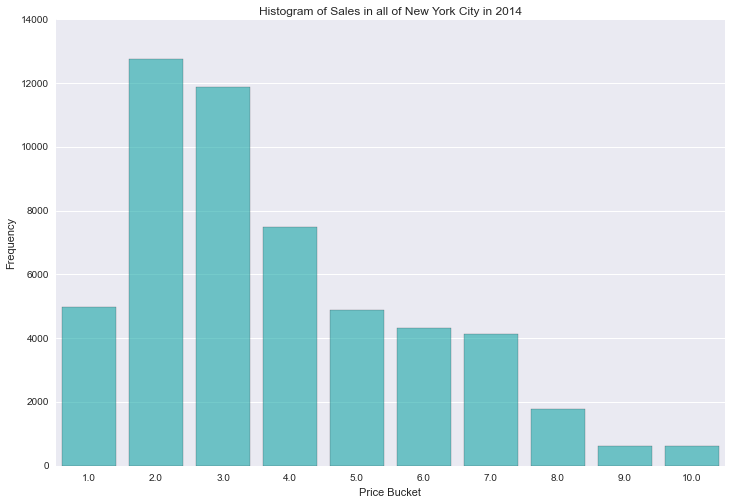

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame.from_dict(count, 'index')
sns.barplot(x=df.index,y=df[0],color='c',alpha=0.6)
plt.title('Histogram of Sales in all of New York City in 2014')
plt.ylabel('Frequency')
plt.xlabel('Price Bucket')
ax.xaxis.get_majorticklocs()
#ax.xaxis.set_ticks(x_ticks)
#plt.xticks([i for i in labels],[str(w) for w in x_ticks]) 

In [19]:
final = final.merge(zipcodes,on='ZIP_CODE',how='inner')
final = gpd.GeoDataFrame(final) # For plotting

### Get Assessment data from DOF in order to compute effective tax rate (ETR)

In [127]:
assessment = pd.read_csv(zip_.open(filename_assessment))
del assessment['Unnamed: 0'] # Delete unnecessary columns

In [128]:
assessment.rename(columns={'BBLE':'BBL'},inplace=True)

In [129]:
assessment.columns

Index([u'BBL', u'BORO', u'BLOCK', u'LOT', u'EASE', u'APTNO', u'TOT_UNIT',
       u'RES_UNIT', u'GR_SQFT', u'CUR_FV_T', u'CURAVT', u'CUREXT', u'CURAVT_A',
       u'CUREXT_A', u'FN_AVT', u'FN_EXT', u'TXCL'],
      dtype='object')

In [130]:
# Make sure BBL is same type for merging
assessment.BBL = assessment.BBL.astype(str)
final.BBL = final.BBL.astype(str)

In [131]:
finale = final.merge(assessment,on='BBL',how='inner')

In [132]:
len(finale) # Approximately 40k observations remain

43255

In [134]:
finale.columns

Index([                 u'ZIP_CODE',                 u'SALE_DATE',
                       u'SALE_YEAR',                u'PRICE_BINS',
            u'TAX_CLASS_AT_PRESENT',          u'APARTMENT_NUMBER',
               u'RESIDENTIAL_UNITS', u'TAX_CLASS_AT_TIME_OF_SALE',
                      u'SALE_PRICE',           u'SALE_PRICE_UNIT',
                             u'BBL',         u'RESIDENTIAL_UNITS',
                     u'TOTAL_UNITS',          u'LAND_SQUARE_FEET',
                        u'TAX_RATE',                  u'geometry',
                            u'BORO',                     u'BLOCK',
                             u'LOT',                      u'EASE',
                           u'APTNO',                  u'TOT_UNIT',
                        u'RES_UNIT',                   u'GR_SQFT',
                        u'CUR_FV_T',                    u'CURAVT',
                          u'CUREXT',                  u'CURAVT_A',
                        u'CUREXT_A',                    u'FN_A

***MARKET VALUES***
- CUR_FV_T = AV-CUR-FULLVAL-TOTAL : If not zero, Current year’s total market value

***ASSESSED VALUES ( ACTUAL & TRANSITIONAL )*** : Contains the Assessed Values for the current fiscal year
- CUREXT = AV-CUREXT : Current Transitional Exempt Total Value
- CUREXT_A = AV-CUREXT-ACT : Current Actual Exempt Total Value
- CURAVT = AV-CURAVT : Current Transitional Assessed Total Value
- CURAVT_A = AV-CURAVT-ACT : Current Actual Assessed Total Value

***FINAL ASSESSED VALUES***
- FN_EXT = AV-FINAL-EXT : Final Transitional Exempt Total Value


### NOTES:
The law requires that the DOF uses whichever number is lower – the actual assessed value or transitional assessed value – to get to your property tax bill.
Your Assessed Value is based on a percentage of your Market Value. This percentage is known as the Level of Assessment or Assessment Ratio. Your Assessment Ratio depends on your tax class.

|Assessment Ratios|Percentage|
|:---------------:|:--------:|
|Tax class 1|	                6%|
|Tax class 2, 3 and 4 |   	45%|

***Transitional***

The DOF phases in changes to the assessed value of Class 2 properties with more than 10 units and Class 4 properties over a five-year period. This means that it applies 20% of the change each year for five years. 

#### Using DOF's Current Year Market Value as an approximation for market value. Using current actual exempt value.
One can do this using final values as well.

In [135]:
# Whole building
finale['TAXABLE_ACTUAL'] = finale['CURAVT_A'] - finale['CUREXT_A']
finale['TAX_PAID'] = finale.TAXABLE_ACTUAL * finale.TAX_RATE
finale['EST_TAX_RATE_ACTUAL'] = np.round((finale['TAX_PAID']/finale['CUR_FV_T'])*100,2) # Market value from DOF

#### Computing the ETR on an apartment level

In [136]:
# RESIDENTIAL UNITS is for some reason a multi-index column
l = np.array(finale['RESIDENTIAL_UNITS'].apply(lambda x: x))
l = l[:,0]
del finale['RESIDENTIAL_UNITS']
finale['RESIDENTIAL_UNITS'] = l

In [170]:
#print ((len(finale['RESIDENTIAL_UNITS'])-list(finale['RESIDENTIAL_UNITS']==finale['RES_UNIT']).count(True))/
#        np.float(len(finale))*100)
print ((len(finale['TOTAL_UNITS'])-list(finale['TOTAL_UNITS']==finale['TOT_UNIT']).count(True))/
        np.float(len(finale))*100)

38.1112010172


***38% of the total units info from the sales data does not match with the units info from assessment data.
Hence we pick assessment data from now on, since this is the information that is considered when paying taxes and thus assumed to be more likely to represent reality.***

In [165]:
# Calculating the number of units
# Total units in building
finale['TAX_UNIT'] = np.where(finale['TOT_UNIT']==0,1,finale['TOT_UNIT'])
# Number of units sold out of total, use sales data because it tells one how many apartments are included in the price
finale['SALE_UNIT'] = np.where(finale['RESIDENTIAL_UNITS']==0,1,finale['RESIDENTIAL_UNITS'])

In [166]:
# Estimate tax rate per unit
# Use AV-TOTAL-UNITS instead of TAX_UNITS, which is f(TOTAL_UNITS)
# because sales data is unreliable with regard to total units
finale['TAX_RATE_PER_UNIT'] = np.round((finale.TAX_PAID/finale['TAX_UNIT'])/
                                       (finale.SALE_PRICE/finale['SALE_UNIT']),4)*100
# TAX_PAID is for the whole building, thus dividing by TAX_UNIT gives us a proxy for the taxes paid by each residential
# unit. To get the final effective tax rate, one divides by the sale price adjusted for whether an apartment was sold
# or the whole building.

#### Using sales price as an approximation for market value. Using current actual exempt value.
Need to check whether sales price includes the whole building or just the apartment, since assessment data is on the whole building.

#### Relationship between Market Value and Sales Price

In [151]:
# Market is taken from DOF calculations and sale price from actual sales adjusted for the units
finale['MKT_SALE'] = np.round(finale.CUR_FV_T/finale.TAX_UNIT/finale.SALE_PRICE_UNIT*100,2)

In [152]:
# Difference between market value and sales price in percentage terms
finale['MKT_SALE_PERC'] = np.round(finale.CUR_FV_T/(finale.SALE_PRICE_UNIT*finale.TOTAL_UNITS)*100,2)

In [153]:
# Percentage of exemptions
finale['EXT_PERC'] = np.round(finale.CUREXT_A/finale.CURAVT_A*100,2)

In [167]:
finale[['TAX_RATE_PER_UNIT','ZIP_CODE']].describe()

,TAX_RATE_PER_UNIT,ZIP_CODE
count,43255.000000,43255.000000
mean,1.174069,10733.445174
std,9.160458,603.999203
min,0.000000,10001.000000
25%,0.490000,10026.000000
50%,0.860000,11201.000000
75%,1.300000,11237.000000
max,857.270000,11694.000000


#### Looking at outliers

In [176]:
# Some data is inconsitent.
# For example here, 102 units are sold for $2,600,000 while the whole building has 105 units
# and paid $2,969,769 in taxes. Thus, the tax rate is higher than 100 Percent...
finale[finale['TAX_RATE_PER_UNIT']>100][['SALE_PRICE','TAX_UNIT','TOT_UNIT',
                                           'RES_UNIT','SALE_UNIT','TAX_PAID','TAX_RATE_PER_UNIT','BBL',
                                         'RESIDENTIAL_UNITS','CURAVT_A','CUREXT_A',
                                         'TOTAL_UNITS','APARTMENT_NUMBER']][:5]

,SALE_PRICE,TAX_UNIT,TOT_UNIT,RES_UNIT,SALE_UNIT,TAX_PAID,TAX_RATE_PER_UNIT,BBL,RESIDENTIAL_UNITS,CURAVT_A,CUREXT_A,TOTAL_UNITS,APARTMENT_NUMBER
1405,2600000,105,105,102,102,2969769.40,110.96,1005760025,102,23217750,373370,105,
13227,755000,100,100,92,92,945454.90,115.21,1014310021,92,7322400,49670,100,
22351,450000,520,520,520,520,1267042.40,281.56,3019020001,520,10346400,599920,520,520
23593,422000,128,128,128,128,457820.87,108.49,3002410012,128,3650400,128701,128,
24478,169845,55,55,55,55,178106.50,104.86,3053280032,55,1395900,25850,55,55


In [174]:
finale[finale['BBL']=='4084890001'][:5]

,ZIP_CODE,SALE_DATE,SALE_YEAR,PRICE_BINS,TAX_CLASS_AT_PRESENT,APARTMENT_NUMBER,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_PRICE_UNIT,BBL,...,TAXABLE_ACTUAL,TAX_PAID,EST_TAX_RATE_ACTUAL,RESIDENTIAL_UNITS,TAX_UNIT,SALE_UNIT,TAX_RATE_PER_UNIT,MKT_SALE,MKT_SALE_PERC,EXT_PERC
38727,11005,2014-01-03,2014,5,2,,2,884604,884604,4084890001,...,122395245,15911381.85,5.17,0,1866,1,0.96,18.64,inf,11.62
38728,11005,2014-01-08,2014,3,2,,2,485000,485000,4084890001,...,122395245,15911381.85,5.17,0,1866,1,1.76,34.01,inf,11.62
38729,11005,2014-01-08,2014,3,2,,2,450000,450000,4084890001,...,122395245,15911381.85,5.17,0,1866,1,1.89,36.65,inf,11.62
38730,11005,2014-01-15,2014,5,2,,2,900000,900000,4084890001,...,122395245,15911381.85,5.17,0,1866,1,0.95,18.33,inf,11.62
38731,11005,2014-01-14,2014,3,2,,2,510000,510000,4084890001,...,122395245,15911381.85,5.17,0,1866,1,1.67,32.34,inf,11.62


In [181]:
len(finale[finale['TAX_RATE_PER_UNIT']>20]) # Forty observations are quite outliers...

40

In [230]:
clean_data = finale[finale['TAX_RATE_PER_UNIT']<20] # Clean data

## ETR data per zipcode for visualization

#### cleans dataset

In [207]:
ETR_UNIT_ZIP = pd.DataFrame({'STD':clean_data.groupby('ZIP_CODE',axis=0)['TAX_RATE_PER_UNIT'].std(),
                            'MEAN':clean_data.groupby('ZIP_CODE',axis=0)['TAX_RATE_PER_UNIT'].mean()}).reset_index()

In [213]:
def plot(df,color,title,column):
    df = df.merge(zipcodes, on='ZIP_CODE',how='inner')
    df_ = gpd.GeoDataFrame(df)
    f, ax = plt.subplots(figsize=(12,8));
    ax.set_axis_bgcolor(color);
    plt.grid('off');
    df_.plot(column=column, scheme='QUANTILES', k=7, alpha=0.6, colormap='YlOrRd', axes=ax, legend=True);
    title = title + ' : ' + column.lower()
    plt.title(title);

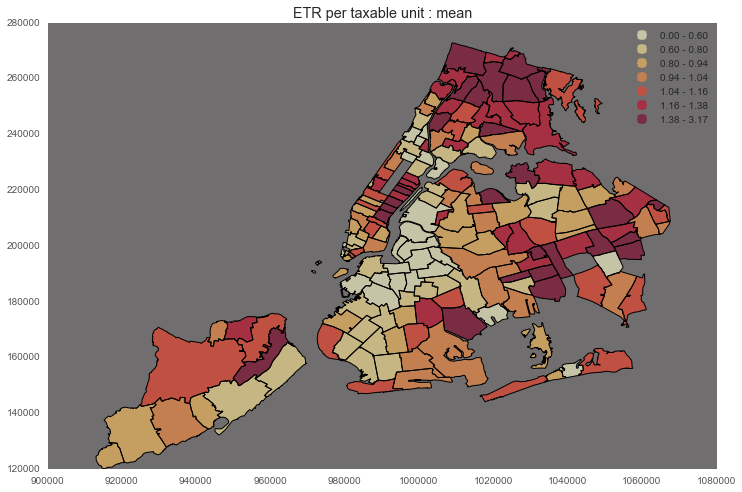

In [214]:
plot(ETR_UNIT_ZIP,'#706E6E','ETR per taxable unit','MEAN')

In [186]:
ETR_BUILDING_ZIP = pd.DataFrame({'STD':clean_data.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].std(),
                            'MEAN':clean_data.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].mean(),
                'MEDIAN':clean_data.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].median()}).reset_index()

In [187]:
ETR_BUILDING_ZIP[:4]

,ZIP_CODE,MEAN,MODE,STD
0,10001,4.006275,5.69,2.199863
1,10002,4.978108,5.37,1.179218
2,10003,5.333908,5.78,1.308685
3,10004,3.241869,2.50,1.308259


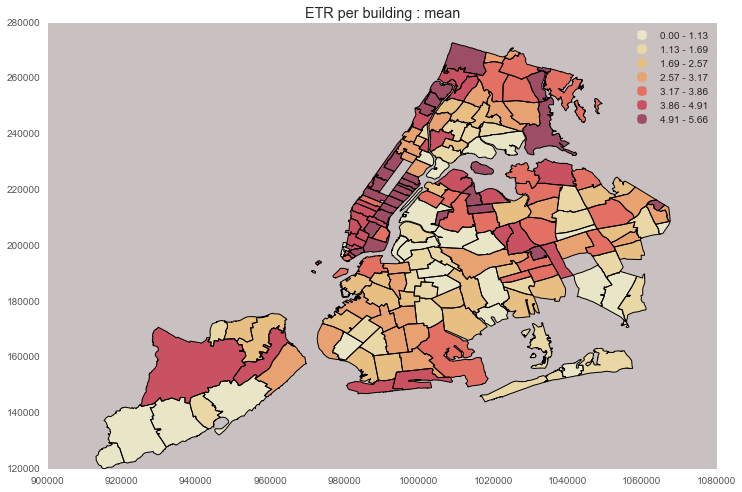

In [215]:
plot(ETR_BUILDING_ZIP,'#C9C1C1','ETR per building','MEAN')

### As a share of income

In [261]:
# Read income data and merge data
income = pd.read_csv(zip_.open(filename_income))
income.drop(0,inplace=True)
income.rename(columns={'GEO.id2':'ZIP_CODE','HC02_EST_VC02':'MEDIAN_INCOME'},inplace=True)
income = income[['ZIP_CODE','MEDIAN_INCOME']]
income['ZIP_CODE'] = income['ZIP_CODE'].astype(int)
income['MEDIAN_INCOME'] = income['MEDIAN_INCOME'].apply(lambda x: x.replace(',','').strip('+').strip())
income['MEDIAN_INCOME'] = np.where(income['MEDIAN_INCOME']=='-',np.nan,income['MEDIAN_INCOME'])
income['MEDIAN_INCOME'] = np.round(income['MEDIAN_INCOME'].astype(float),1)
data_with_income = income.merge(clean_data,how='inner',on='ZIP_CODE')

In [288]:
data_with_income['ETR_UNIT_SHARE_OF_INCOME'] = (((data_with_income['TAX_RATE_PER_UNIT']/100)*
                                                data_with_income['MEDIAN_INCOME'])/data_with_income['MEDIAN_INCOME'])*100

In [290]:
ETR_SHARE_INCOME_ZIP = pd.DataFrame({'STD':data_with_income.groupby('ZIP_CODE',axis=0)['ETR_UNIT_SHARE_OF_INCOME'].std(),
                'MEAN':data_with_income.groupby('ZIP_CODE',axis=0)['ETR_UNIT_SHARE_OF_INCOME'].mean(),
                'MEDIAN':data_with_income.groupby('ZIP_CODE',axis=0)['ETR_UNIT_SHARE_OF_INCOME'].median()}).reset_index()

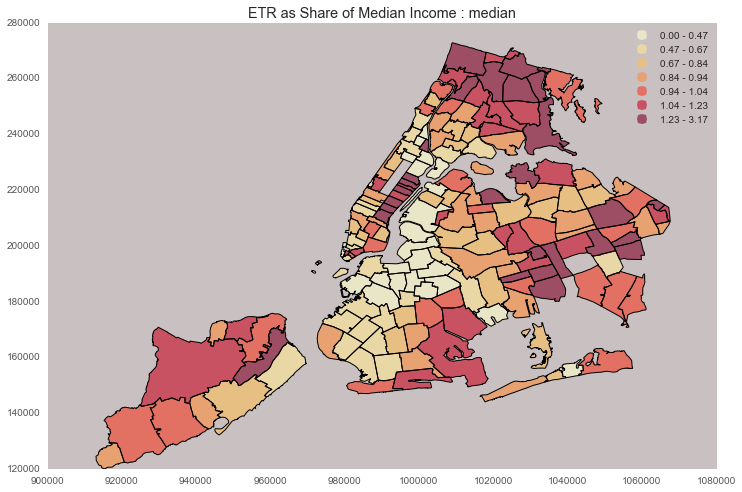

In [291]:
plot(ETR_SHARE_INCOME_ZIP,'#C9C1C1','ETR as Share of Median Income','MEDIAN')

### Summaries by Zip Codes

In [292]:
# Get statistics
print final['SALE_PRICE'].groupby(final['TAX_CLASS_AT_TIME_OF_SALE']).mean()
print final['SALE_PRICE'].groupby(final['TAX_CLASS_AT_TIME_OF_SALE']).std()

# Get summaries
tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                     'PRICE_BINS'],axis=0).size()}).reset_index()
total_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                       'PRICE_BINS','ZIP_CODE'],axis=0).size()}).reset_index()
total1 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==1]['COUNT'].sum()
total2 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2]['COUNT'].sum()
tax_breakdown['SHARE'] = np.where(tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2,
                                  tax_breakdown['COUNT']/total2, tax_breakdown['COUNT']/total1)
del total1
del total2

zip_tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['ZIP_CODE','TAX_CLASS_AT_TIME_OF_SALE'],axis=0).size()}).reset_index()
total_per_zip = pd.DataFrame({'TOTAL_COUNT':final.groupby(['ZIP_CODE'],axis=0).size()}).reset_index()

# Normalize each count by total sales count and maybe by population
zip_tax_breakdown = zip_tax_breakdown.merge(total_per_zip,on='ZIP_CODE',how='inner')
del total_per_zip

TAX_CLASS_AT_TIME_OF_SALE
1     667379
2    1681503
Name: SALE_PRICE, dtype: int64
TAX_CLASS_AT_TIME_OF_SALE
1     1054259.143807
2    20866353.842416
Name: SALE_PRICE, dtype: float64


In [293]:
zip_tax_breakdown.head() # Add share of tax class two per zip code, merge it with tax data for tableu.

,ZIP_CODE,TAX_CLASS_AT_TIME_OF_SALE,COUNT,TOTAL_COUNT
0,10001,1,2,175
1,10001,2,173,175
2,10002,1,1,296
3,10002,2,295,296
4,10003,1,5,805


In [294]:
total_breakdown.head() 

,TAX_CLASS_AT_TIME_OF_SALE,PRICE_BINS,ZIP_CODE,COUNT
0,1,1,10301,25
1,1,1,10302,17
2,1,1,10303,41
3,1,1,10304,38
4,1,1,10305,15


In [ ]:
# Get price bin info per zip code, without tax class at time of sale
#